In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import cv2

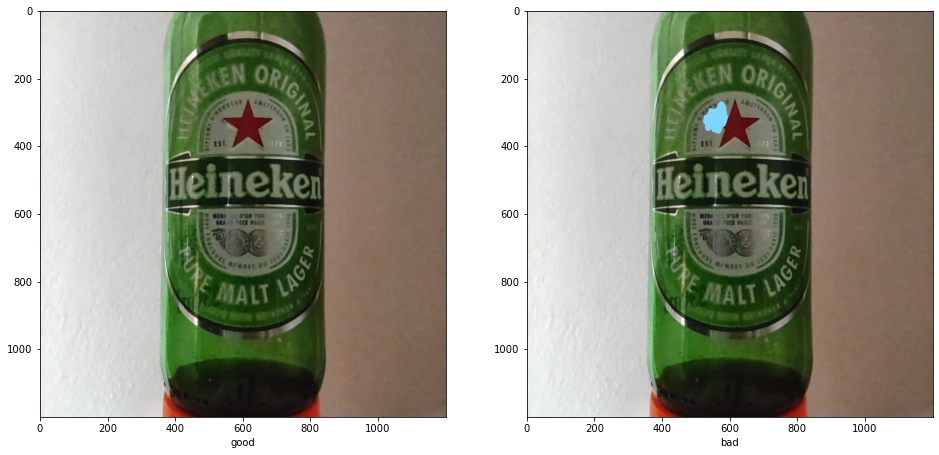

In [3]:
imgs = OrderedDict()
imgs['good'] = plt.imread('images\\bad images\\middle3.jpg')
imgs['bad'] = plt.imread('images\\bad images\\middle3_modified.jpg')

imgs_gray = OrderedDict()
for i, key in enumerate(imgs):
    imgs_gray[key] = cv2.cvtColor(imgs[key], cv2.COLOR_RGB2GRAY)
    
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for i, key in enumerate(imgs):
    axs[i].imshow(imgs[key])
    axs[i].set_xlabel(f'{key}')
plt.show()

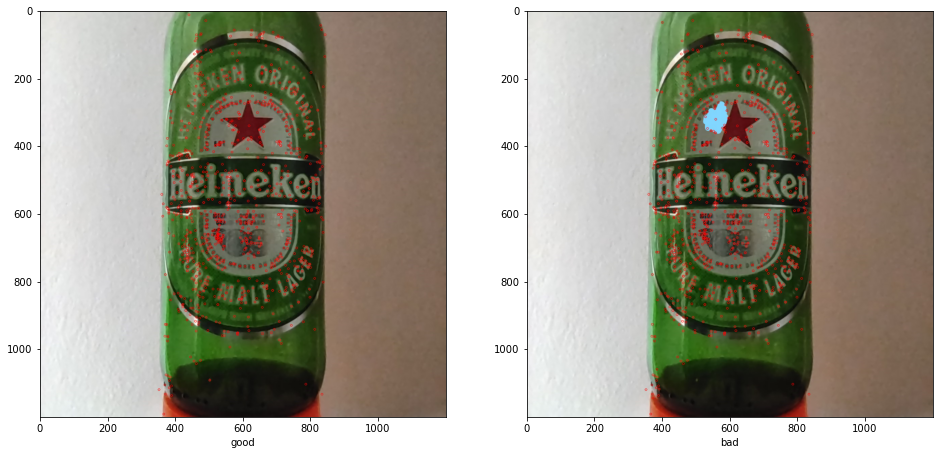

In [4]:
sift = cv2.SIFT_create()

kpts = OrderedDict()
features = OrderedDict()

for key in imgs.keys():
    kpts[key], features[key] = sift.detectAndCompute(imgs_gray[key], None)

fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for i, key in enumerate(imgs):
    axs[i].imshow(cv2.drawKeypoints(imgs[key], kpts[key], None, color=(255, 0, 0)))
    axs[i].set_xlabel(f'{key}')
plt.show()

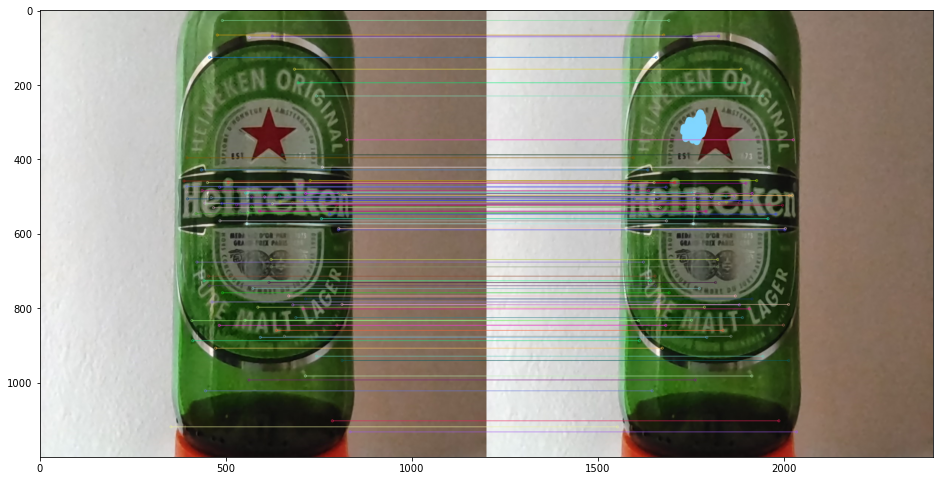

In [5]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
best_matches = bf.match(features['good'], features['bad'])
matches = sorted(best_matches, key=lambda x:x.distance)

img_matches = cv2.drawMatches(imgs['good'], kpts['good'],
                             imgs['bad'], kpts['bad'], 
                             matches[:100], None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 9))
plt.imshow(img_matches)
plt.show()

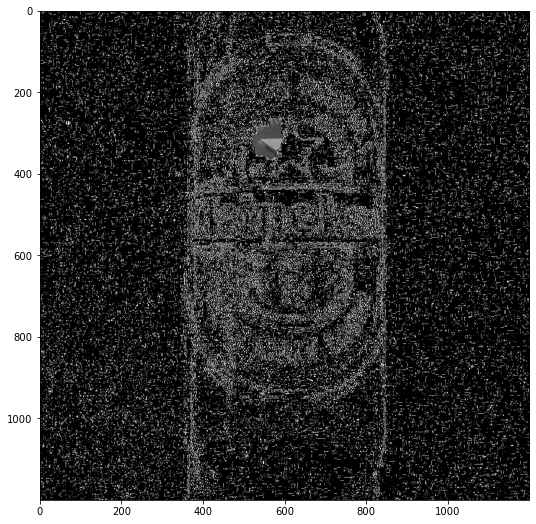

In [6]:
img_diff = imgs_gray['bad'] - imgs_gray['good']
plt.figure(figsize=(16, 9))
plt.imshow(img_diff, 'gray')
plt.show()

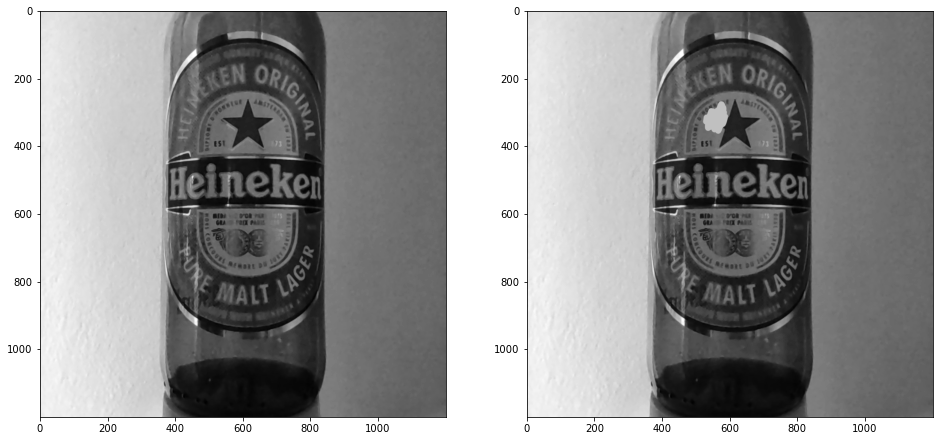

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for i, key in enumerate(imgs):
    axs[i].imshow(imgs_gray[key], 'gray')
plt.show()

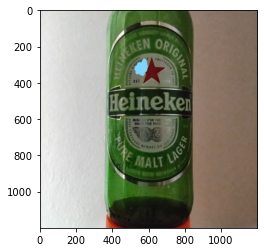

In [8]:
stitcher = cv2.Stitcher_create(0)
result = stitcher.stitch(imgs['good'], imgs['bad'])
plt.imshow(result[1])
plt.show()

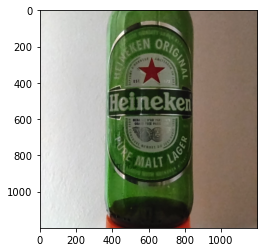

In [9]:
imgs['middle'] = plt.imread('images\\bad images\\middle3.jpg')
imgs['left'] = plt.imread('images\\bad images\\left3.jpg')
stitcher = cv2.Stitcher_create(0)
result = stitcher.stitch(imgs['left'], imgs['middle'])
plt.imshow(result[1])
plt.show()

In [10]:
def SIFT(imgs, keys):
    sift = cv2.SIFT_create()

    kpts = OrderedDict()
    features = OrderedDict()

    for key in keys:
        kpts[key], features[key] = sift.detectAndCompute(imgs_gray[key], None)

    return kpts, features

def matcher(features_A, features_B):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    best_matches = bf.match(features_A, features_B)
    rawMatches = sorted(best_matches, key=lambda x:x.distance)
    return rawMatches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

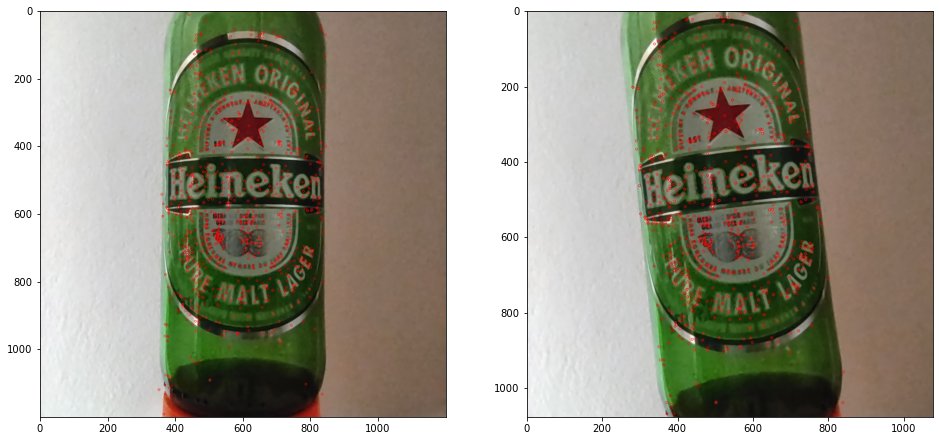

In [12]:
imgs['tilt'] = plt.imread('images\\bad images\\tilt.jpg')
imgs_gray['tilt'] = cv2.cvtColor(imgs['tilt'], cv2.COLOR_RGB2GRAY)
keys = ['good', 'tilt']

kpts, features = SIFT(imgs_gray, keys)

fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for i, k in enumerate(keys):
    axs[i].imshow(cv2.drawKeypoints(imgs[k], kpts[k], None, color=(255, 0, 0)))
plt.show()

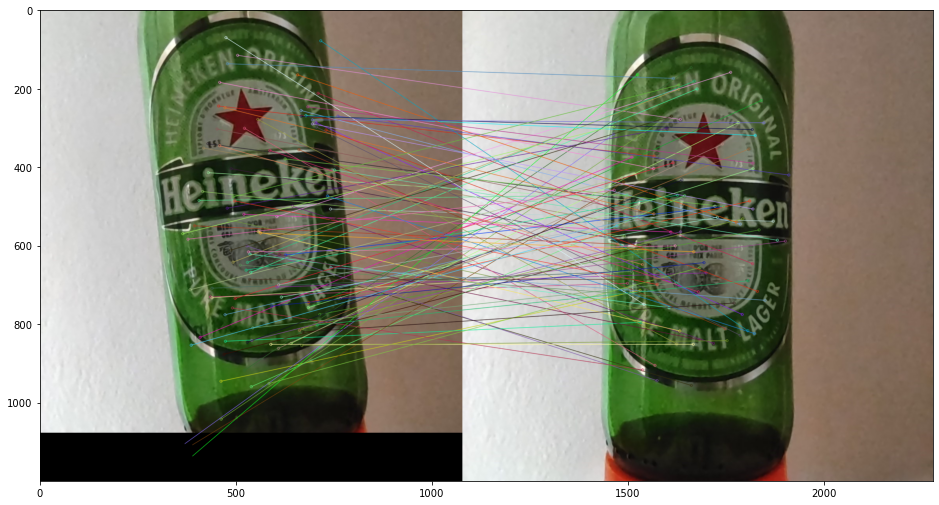

In [13]:
matches = matcher(features['tilt'], features['good'])
img_match = cv2.drawMatches(imgs['tilt'], kpts['good'], 
                           imgs['good'], kpts['good'], 
                           matches[:100], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 9))
plt.imshow(img_match)
plt.show()

In [14]:
M = getHomography(kpts['tilt'], kpts['good'],
                  features['tilt'], features['good'],
                  matches, reprojThresh=4)
(matches, H, status) = M
H

array([[ 9.92550921e-01, -1.21780096e-01,  1.30604028e+02],
       [ 1.21785155e-01,  9.92488910e-01, -5.87098469e-01],
       [ 8.15625902e-08, -1.49846842e-07,  1.00000000e+00]])

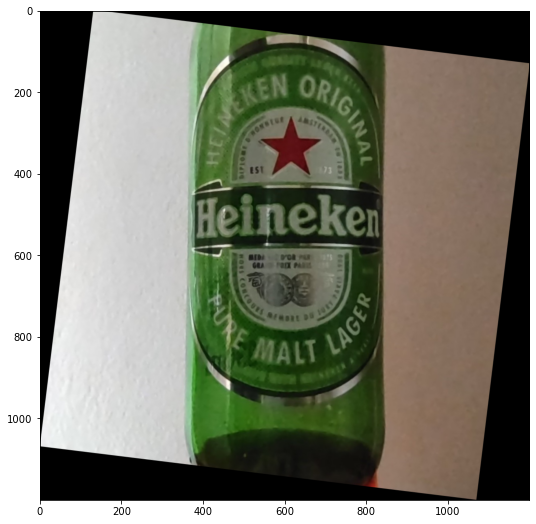

In [15]:
result = cv2.warpPerspective(imgs['tilt'], H, (imgs['good'].shape[0], imgs['good'].shape[1]))
plt.figure(figsize=(16, 9))
plt.imshow(result)
plt.show()

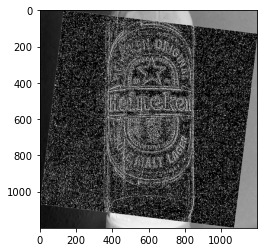

In [21]:
resultGray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
diff = resultGray - imgs_gray['good']
plt.imshow(diff, 'gray')